# LTSF-Linear family
- Linear : one linear layer
- DLinear : Decomposition Linear -> trend와 seasonality 패턴을 핸들링
- NLinear : 정규화된 Linear로서 train-test set 분포 변화를 다룬다. 

In [38]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


### (1) Linear
- 단 하나의 선형 레이어로 구성된 모델이지만 트랜스포머 모델보다 성능이 우수하다.

In [2]:
class LTSF_Linear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forcast_size  = forcast_size
        self.individual = individual  # ????
        self.channels = feature_size
        if self.individual: # ?????
            self.Linear = torch.nn.ModuleList() # python List와
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

        
    def forward(self, x): # 모델이 학습 데이터를 입력받아서 forward 연산을 진행시키는 함수
        if self.individual:
            output = torch.zeros([x.size(0), self.pred_len, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        return x

### (2) DLinear
- DLinear : Autoformer와 FEDformer에서 사용되는 시계열 분해 방식을 선형 레이어와 결합한 모델.
1) 먼저 이동 평균값을 만들고 이를 제거하여 각각 학습하기 위해 추세와 주기성 데이터로 분해.
2) 그런 다음 각 구성 요소에 단일 선형 레이어를 적용하여 학습하고 두 개를 합산하여 최종 예측을 계산
3) Dlinear는 시계열 데이터의 명확한 추세와 주기성이 있을 때 바닐라 선형 모델보다 더 나은 성능을 가질 수 있다.

In [5]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size = kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size -1) //2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0,2,1)
        return x
    

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual
    

class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decomposition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size 
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList() # 리스트 초기화 선언 같은거
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels): # feature_size 만큼
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size) * torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size) * torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))


    def forward(self, x):
        trend_init, seasonal_init = self.decomposition(x)
        trend_init, seasonal_init = trend_init.permute(0, 2, 1), seasonal_init.permute(0, 2, 1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:,idx,:])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x= seasonal_output + trend_output
        return x.permute(0, 2, 1)


### (3) NLinear
- 상승하거나 하락하는 추세를 지녔을 경우 학습 데이터의 평균과 분산으로 데이터를 정규화시키면 평가 데이터에 분포 이동이 발생할 수 있음. -> 학습된 모형의 예측값은 분포에서 크게 벗어나기 때문에 예측성능이 하락
- 따라서 NLinear 모델은 이를 개선하기 위해 마지막 값을 빼서 모델을 학습시키고 가장 마지막에 그 값을 더해서 실제값이 존재하는 분포로 이동시킨다.
- 학습 데이터와 평가 데이터의 분포 차이는 ETth1, ETth2, ILI 벤치마크 데이터셋에서 관찰되었고 실험 결과 높은 성능을 보여줌

In [6]:
class LTSF_NLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)

    
    def forward(self, x):
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)], dtype= x.dtype).to(x.device)
            for i in range(self.channels):
                output[:, :, i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0, 2, 1)).permute(0,2,1)
        x = x+seq_last
        return x

### 전력사용량 적용
- 사용할 모델은 총 4개로 바닐라 트랜스포머, Linear, DLinear, NLinear
- 학습 데이터 전처리의 경우 정규화와 Sliding window를 진행
- window_size = 72, forcast size = 24, batch size =32, lr=1e-4, loss = MSE, opt = Adam
- 평가 데이터 기준 가장 높은 성능의 모델을 저장하여 실험 진행

In [48]:
# 정규화
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std

        if x ==target: # 테스트 데이터셋에서는 target이 없다.
            continue
        else:
            test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]


# sliding window
def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)


class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size = 720
batch_size = 32
targets = '전력사용량'
date = 'date_time'



# 데이터 불러오기 
train = pd.read_csv('./data/train.csv', encoding='cp949')
# test_df = pd.read_csv('./data/test.csv', encoding='cp949') 타겟값 없으니까 제외

train_df, test_df = train_test_split(train, test_size=0.2, random_state=311, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# 컬럼 전처리 하기

for col_nm in train_df.columns:
    if '(' in col_nm:
        new_col_nm = col_nm.split('(')[0]
        train_df.rename(columns = {col_nm : new_col_nm}, inplace=True)


for col_nm in test_df.columns:
    if '(' in col_nm:
        new_col_nm = col_nm.split('(')[0]
        test_df.rename(columns = {col_nm : new_col_nm}, inplace=True)

# 정규화
train_df_fe, test_df_fe, mean, std = standardization(train_df, test_df, 'date_time', targets)



# sliding window -> 타겟값만 대상으로 데이터셋 재구성
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)




# train & valid & test split
train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)


# DataLoader 모듈 사용
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,) # shuffle True 해도 되나?
valid_dl = DataLoader(valid_ds, batch_size=train_x[1000:].shape[0], shuffle=False )
test_dl = DataLoader(test_ds, batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
    window_size = window_size,
    forcast_size = forcast_size,
    kernel_size = 25, # 왜 kernel_size는 25일까
    individual = False,
    feature_size=1,
)


criterion = torch.nn.MSELoss() # 모델 성능 기준
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr = lr)
max_loss = 999999999


##################################################### 학습 ###################################################
for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train() # sets the module in training mode 
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad() # pytorch에서는 gradients 값들을 추후에 backward를 해줄 때 계속 더해주기 때문에 항상 backpropagation을 하기전에 gradients를 zero로 만들어주고 시작해야한다.
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1)) # -1은 인덱스상으로 마지막 차원을 의미. 마지막 차원에 1인 차원을 추가. 원래 크기가 (3,)이라고 할 때 (3,1)의 크기를 갖게 된다. (암튼 차원이 추가된다.)
        loss.backward() # backward를 통해 gradient를 계싼
        optimizer.step() # 
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval() # 모듈을 evaluation mode로 세팅. 
    with torch.no_grad(): # 이렇게 작성하면 pytorch는 autograd engine을 꺼버린다. 즉 더이상 자동으로 gradient를 트래킹하지 않는다는 말. 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산속도를 높이기 위함
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)


        # 이 코드는 실행 안될거다. 왜냐면 test_dl에 
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1)) # 이부분 수행 불가능할거다 -> 원래는 불가능한데 타겟값 있게 만들어줘서 가능
            test_loss_list.append(test_loss) # 이 부분 수행 불가능할거다 -> 원래는 불가능한데 타겟값 있게 만들어줘서 가능

    if valid_loss < max_loss:
        torch.save(DLinear_model, './model/DLinear_model.pth') # Pytorch에서는 모델을 저장할 때 .pt 또는 .pth 확장자를 사용하는 것이 일반적인 규칙
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_loss{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))









    

  2%|▏         | 1/50 [00:01<00:55,  1.14s/it]

valid_loss=0.443, test_loss1475505.250, Model Save
epoch = 1, train_loss : 0.006, valid_loss : 0.443, test_loss : 1475505.250


  4%|▍         | 2/50 [00:02<00:53,  1.12s/it]

valid_loss=0.430, test_loss1453758.625, Model Save
epoch = 2, train_loss : 0.003, valid_loss : 0.430, test_loss : 1453758.625


  6%|▌         | 3/50 [00:03<00:52,  1.12s/it]

valid_loss=0.426, test_loss1443874.625, Model Save
epoch = 3, train_loss : 0.003, valid_loss : 0.426, test_loss : 1443874.625


  8%|▊         | 4/50 [00:04<00:51,  1.12s/it]

epoch = 4, train_loss : 0.003, valid_loss : 0.427, test_loss : 1446531.875


 10%|█         | 5/50 [00:05<00:50,  1.12s/it]

valid_loss=0.425, test_loss1441433.625, Model Save
epoch = 5, train_loss : 0.003, valid_loss : 0.425, test_loss : 1441433.625


 12%|█▏        | 6/50 [00:06<00:49,  1.12s/it]

epoch = 6, train_loss : 0.003, valid_loss : 0.427, test_loss : 1447002.625


 14%|█▍        | 7/50 [00:07<00:48,  1.12s/it]

valid_loss=0.424, test_loss1437355.750, Model Save
epoch = 7, train_loss : 0.003, valid_loss : 0.424, test_loss : 1437355.750


 16%|█▌        | 8/50 [00:08<00:47,  1.13s/it]

epoch = 8, train_loss : 0.003, valid_loss : 0.424, test_loss : 1439145.375


 18%|█▊        | 9/50 [00:10<00:45,  1.11s/it]

valid_loss=0.423, test_loss1436735.125, Model Save
epoch = 9, train_loss : 0.003, valid_loss : 0.423, test_loss : 1436735.125


 20%|██        | 10/50 [00:11<00:44,  1.11s/it]

valid_loss=0.419, test_loss1423070.375, Model Save
epoch = 10, train_loss : 0.002, valid_loss : 0.419, test_loss : 1423070.375


 22%|██▏       | 11/50 [00:12<00:43,  1.11s/it]

epoch = 11, train_loss : 0.003, valid_loss : 0.420, test_loss : 1424733.625


 24%|██▍       | 12/50 [00:13<00:41,  1.10s/it]

epoch = 12, train_loss : 0.002, valid_loss : 0.423, test_loss : 1432382.375


 26%|██▌       | 13/50 [00:14<00:40,  1.10s/it]

epoch = 13, train_loss : 0.002, valid_loss : 0.422, test_loss : 1429788.750


 28%|██▊       | 14/50 [00:15<00:39,  1.10s/it]

epoch = 14, train_loss : 0.002, valid_loss : 0.420, test_loss : 1425979.125


 30%|███       | 15/50 [00:16<00:38,  1.10s/it]

valid_loss=0.418, test_loss1420259.000, Model Save
epoch = 15, train_loss : 0.003, valid_loss : 0.418, test_loss : 1420259.000


 32%|███▏      | 16/50 [00:17<00:37,  1.10s/it]

valid_loss=0.415, test_loss1411301.875, Model Save
epoch = 16, train_loss : 0.003, valid_loss : 0.415, test_loss : 1411301.875


 34%|███▍      | 17/50 [00:18<00:36,  1.10s/it]

epoch = 17, train_loss : 0.003, valid_loss : 0.421, test_loss : 1426812.250


 36%|███▌      | 18/50 [00:19<00:35,  1.10s/it]

epoch = 18, train_loss : 0.002, valid_loss : 0.422, test_loss : 1428657.125


 38%|███▊      | 19/50 [00:21<00:34,  1.10s/it]

epoch = 19, train_loss : 0.003, valid_loss : 0.422, test_loss : 1430581.250


 40%|████      | 20/50 [00:22<00:32,  1.10s/it]

epoch = 20, train_loss : 0.003, valid_loss : 0.418, test_loss : 1415733.000


 42%|████▏     | 21/50 [00:23<00:31,  1.09s/it]

epoch = 21, train_loss : 0.002, valid_loss : 0.416, test_loss : 1412259.375


 44%|████▍     | 22/50 [00:24<00:30,  1.09s/it]

valid_loss=0.415, test_loss1409077.875, Model Save
epoch = 22, train_loss : 0.002, valid_loss : 0.415, test_loss : 1409077.875


 46%|████▌     | 23/50 [00:25<00:29,  1.10s/it]

epoch = 23, train_loss : 0.002, valid_loss : 0.421, test_loss : 1427346.250


 48%|████▊     | 24/50 [00:26<00:28,  1.09s/it]

epoch = 24, train_loss : 0.002, valid_loss : 0.421, test_loss : 1426541.500


 50%|█████     | 25/50 [00:27<00:27,  1.09s/it]

epoch = 25, train_loss : 0.002, valid_loss : 0.419, test_loss : 1418907.125


 52%|█████▏    | 26/50 [00:28<00:26,  1.09s/it]

epoch = 26, train_loss : 0.002, valid_loss : 0.419, test_loss : 1418703.875


 54%|█████▍    | 27/50 [00:29<00:25,  1.09s/it]

epoch = 27, train_loss : 0.002, valid_loss : 0.418, test_loss : 1414837.125


 56%|█████▌    | 28/50 [00:30<00:24,  1.09s/it]

epoch = 28, train_loss : 0.002, valid_loss : 0.418, test_loss : 1414967.000


 58%|█████▊    | 29/50 [00:31<00:22,  1.09s/it]

epoch = 29, train_loss : 0.002, valid_loss : 0.419, test_loss : 1416808.500


 60%|██████    | 30/50 [00:33<00:21,  1.09s/it]

epoch = 30, train_loss : 0.002, valid_loss : 0.418, test_loss : 1414228.250


 62%|██████▏   | 31/50 [00:34<00:20,  1.09s/it]

epoch = 31, train_loss : 0.002, valid_loss : 0.416, test_loss : 1408414.625


 64%|██████▍   | 32/50 [00:35<00:19,  1.09s/it]

epoch = 32, train_loss : 0.002, valid_loss : 0.418, test_loss : 1414109.250


 66%|██████▌   | 33/50 [00:36<00:18,  1.09s/it]

epoch = 33, train_loss : 0.002, valid_loss : 0.418, test_loss : 1413595.250


 68%|██████▊   | 34/50 [00:37<00:17,  1.09s/it]

epoch = 34, train_loss : 0.002, valid_loss : 0.419, test_loss : 1414379.125


 70%|███████   | 35/50 [00:38<00:16,  1.09s/it]

epoch = 35, train_loss : 0.002, valid_loss : 0.420, test_loss : 1417965.625


 72%|███████▏  | 36/50 [00:39<00:15,  1.10s/it]

epoch = 36, train_loss : 0.002, valid_loss : 0.423, test_loss : 1427678.750


 74%|███████▍  | 37/50 [00:40<00:14,  1.10s/it]

epoch = 37, train_loss : 0.002, valid_loss : 0.420, test_loss : 1417331.375


 76%|███████▌  | 38/50 [00:41<00:13,  1.10s/it]

epoch = 38, train_loss : 0.002, valid_loss : 0.422, test_loss : 1423422.625


 78%|███████▊  | 39/50 [00:42<00:12,  1.10s/it]

epoch = 39, train_loss : 0.002, valid_loss : 0.421, test_loss : 1419285.125


 80%|████████  | 40/50 [00:44<00:11,  1.10s/it]

epoch = 40, train_loss : 0.002, valid_loss : 0.417, test_loss : 1410062.250


 82%|████████▏ | 41/50 [00:45<00:09,  1.10s/it]

epoch = 41, train_loss : 0.002, valid_loss : 0.418, test_loss : 1412475.500


 84%|████████▍ | 42/50 [00:46<00:08,  1.10s/it]

epoch = 42, train_loss : 0.002, valid_loss : 0.418, test_loss : 1412663.625


 86%|████████▌ | 43/50 [00:47<00:07,  1.09s/it]

epoch = 43, train_loss : 0.002, valid_loss : 0.423, test_loss : 1424213.250


 88%|████████▊ | 44/50 [00:48<00:06,  1.09s/it]

epoch = 44, train_loss : 0.002, valid_loss : 0.420, test_loss : 1415456.750


 90%|█████████ | 45/50 [00:49<00:05,  1.09s/it]

epoch = 45, train_loss : 0.002, valid_loss : 0.420, test_loss : 1416964.000


 92%|█████████▏| 46/50 [00:50<00:04,  1.09s/it]

epoch = 46, train_loss : 0.002, valid_loss : 0.420, test_loss : 1416031.375


 94%|█████████▍| 47/50 [00:51<00:03,  1.09s/it]

epoch = 47, train_loss : 0.002, valid_loss : 0.421, test_loss : 1418903.875


 96%|█████████▌| 48/50 [00:52<00:02,  1.09s/it]

epoch = 48, train_loss : 0.002, valid_loss : 0.420, test_loss : 1414548.875


 98%|█████████▊| 49/50 [00:53<00:01,  1.09s/it]

epoch = 49, train_loss : 0.002, valid_loss : 0.419, test_loss : 1412250.500


100%|██████████| 50/50 [00:54<00:00,  1.10s/it]

epoch = 50, train_loss : 0.002, valid_loss : 0.421, test_loss : 1416297.750


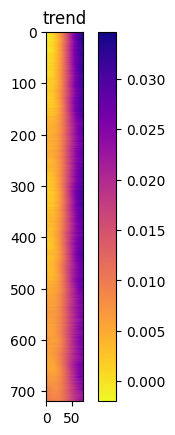

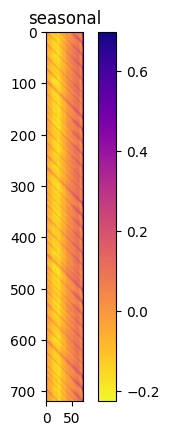

In [49]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()

In [43]:
display(train_df_fe)
window_size = 72
forcast_size = 720
targets = '전력사용량'
date = 'date_time'

df = train_df_fe.copy()
data_list = []
dap_list = []
date_list = []
for idx in range(0, df.shape[0]-window_size, forcast_size+1):
    x = df.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
    y = df.loc[idx+window_size:idx+window_size+forcast_size-1, target].values
    date_ = df.loc[idx+window_size:idx+window_size+forcast_size-1,date].values

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
120718,1.704285,2020-06-15 22,0.383777,-1.453702,1.151239,0.762103,-0.196458,-0.577861,0.680951,1.035511
119412,1.646586,2020-07-16 12,-0.436787,0.248326,-0.892370,-1.042992,-0.196458,1.309688,0.680951,-0.965697
39012,-0.603687,2020-06-11 12,-0.426682,1.158031,0.887547,-1.236395,-0.196458,1.848988,-1.468519,-0.965697
25446,-1.007583,2020-07-11 06,-0.707961,-0.573343,-1.419753,0.633168,-0.196458,-0.577861,0.680951,-0.965697
4946,-1.584576,2020-07-07 02,0.447912,-0.778760,-0.694602,0.762103,-0.196458,-0.577861,0.680951,1.035511
...,...,...,...,...,...,...,...,...,...,...
109880,1.358089,2020-08-13 08,3.220801,0.805887,0.096473,0.697635,-0.196458,-0.577861,0.680951,-0.965697
41958,-0.545988,2020-07-19 06,-0.552073,-0.133163,0.162396,-0.656186,-0.196458,-0.577861,-1.468519,1.035511
87133,0.723397,2020-07-31 13,0.054043,1.304757,-0.299064,-0.333847,-0.196458,-0.577861,0.680951,1.035511
84672,0.665698,2020-07-14 00,-0.775802,-1.805846,0.162396,1.084441,2.686215,-0.577861,0.680951,1.035511


KeyError: '전력사용량(kWh)'

In [44]:
df

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
120718,1.704285,2020-06-15 22,0.383777,-1.453702,1.151239,0.762103,-0.196458,-0.577861,0.680951,1.035511
119412,1.646586,2020-07-16 12,-0.436787,0.248326,-0.892370,-1.042992,-0.196458,1.309688,0.680951,-0.965697
39012,-0.603687,2020-06-11 12,-0.426682,1.158031,0.887547,-1.236395,-0.196458,1.848988,-1.468519,-0.965697
25446,-1.007583,2020-07-11 06,-0.707961,-0.573343,-1.419753,0.633168,-0.196458,-0.577861,0.680951,-0.965697
4946,-1.584576,2020-07-07 02,0.447912,-0.778760,-0.694602,0.762103,-0.196458,-0.577861,0.680951,1.035511
...,...,...,...,...,...,...,...,...,...,...
109880,1.358089,2020-08-13 08,3.220801,0.805887,0.096473,0.697635,-0.196458,-0.577861,0.680951,-0.965697
41958,-0.545988,2020-07-19 06,-0.552073,-0.133163,0.162396,-0.656186,-0.196458,-0.577861,-1.468519,1.035511
87133,0.723397,2020-07-31 13,0.054043,1.304757,-0.299064,-0.333847,-0.196458,-0.577861,0.680951,1.035511
84672,0.665698,2020-07-14 00,-0.775802,-1.805846,0.162396,1.084441,2.686215,-0.577861,0.680951,1.035511


In [35]:
train_df_fe.shape[0]

122400

In [23]:
# 결국은 time_slide_df 함수에서 타겟값만 대상으로 뽑아낸다

,num,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
test_df

,num,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
train_df

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,-1.703413,2020-06-01 00,2.843238,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,-1.703413,2020-06-01 01,2.822152,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,-1.703413,2020-06-01 02,2.808305,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,-1.703413,2020-06-01 03,2.779980,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,-1.703413,2020-06-01 04,2.777462,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,1.703413,2020-08-24 19,0.869130,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,1.703413,2020-08-24 20,0.801780,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,1.703413,2020-08-24 21,0.605817,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,1.703413,2020-08-24 22,0.473217,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [ ]:
class moving_avg(nn.Module): # Module은 또한 다른 모듈들을 담고있다, tree구조로 품고 있다. submodule들을 특성들로 할당할 수 있다.
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        # time series에서 양쪽 끝에 패딩하기
        front = x[:, 0:1, :].repeat(1, (self.kernel_size-1) // 2, 1) # kernel_size : 연산을 수행할 때 윈도우의 크기를 의미
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1)) # torch.permute() 는 원하는 순서로 원본 텐서를 재정렬하고 새로운 차원으로 반환할 수 있다.
        x = x.permute(0,2,1)
        return x
    


class series_decomp(nn.Module): # nn.Module을 상속받는다는 의미 같다.
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__() # 자식 클래스가 상속받는 부모 클래스를 자식 클래스에 불러오겠다는 의미 -> 그냥 상속받는다는 의미 super().__init()__과 차이없음.
        self.moving_avg = moving_avg(kernel_size, stried=1)

    def forward(self, x): 
        moving_mean = self.moving_avg(x)
        res = x - moving_mean # 잔차 구하는거 같다.
        return res, moving_mean # 잔차와 trend 반환
    


class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs): # configs에 어떤 정보 받아져있는지 확인해볼 필요 있다.
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decomposition Kernel Size
        kernel_size = 25 # ???????????????????????????????????
        self.decomposition = series_decomp(kernel_size) # 위에 25로 설정했으니 25개의 moving avg 찍는다.
        self.individual = configs.individual # ???????????????????????
        self.channels = configs.enc_in # ????????????????????????

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    
    def forward(self, x):
        # x : [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])

        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1) # to [Batch, Output length, Channel]

                



    

